### **DCGAN with MNIST Dataset**

**Importing Libraries**

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython import display
from PIL import Image
from tqdm import tqdm
import glob
import imageio.v2 as imageio

In [12]:
epochs=50
z_dim=64
batch_size=128
buffer_size=1024

In [4]:
train_dataset, info = tfds.load("mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
info

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1.incompleteUS1A3J',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",

In [5]:
def preprocessing(image, label):
  image = tf.cast(image, dtype=tf.float32)/127.5 -1
  return image

In [6]:
train_dataset = (train_dataset
                 .map(preprocessing)
                 .shuffle(buffer_size, seed=123)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

In [7]:
for examples in train_dataset.take(1):
  print(examples.shape)

(128, 28, 28, 1)


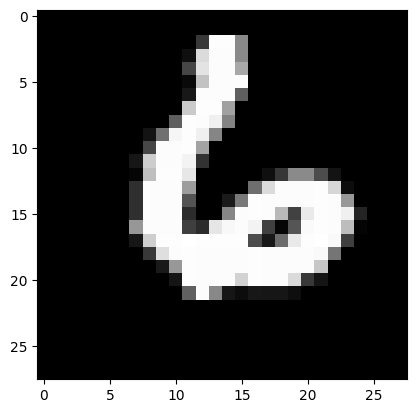

In [8]:
plt.imshow(examples[0], cmap="gray");

In [57]:
# Display functions

def make_grid(images, num_examples, nrow):
  images=tf.unstack(images[:num_examples], axis=0)
  images=tf.concat(images, axis=1)
  images=tf.split(images, nrow, axis=1)
  images=tf.concat(images, axis=0)

  return images

def show_and_save_images(real_images, fake_images, epoch, images_gif_size, num_examples=25, nrow=5, cmap="gray"):

  real_images=make_grid(real_images, num_examples, nrow)
  fake_images=make_grid(fake_images, num_examples, nrow)
  real_images = tf.cast((real_images+1) * 127.5, tf.uint8) # Denormalization
  fake_images = tf.cast((fake_images+1) * 127.5, tf.uint8)

  save_images = fake_images.numpy().squeeze()
  save_images = Image.fromarray(save_images)
  save_images = save_images.resize(images_gif_size)
  save_images.save(f"images/image_at_epoch_{epoch:03d}.png")

  fig, ax = plt.subplots(1, 2, figsize=(nrow*2, nrow*2))
  ax[0].imshow(fake_images, cmap=cmap)
  ax[0].axis("off")
  ax[0].set_title("Generated Images")

  ax[1].imshow(real_images, cmap=cmap)
  ax[1].axis("off")
  ax[1].set_title("Real Images")

  plt.show()

In [58]:
# Function to graph losses

def plot_metrics(history, epochs=epochs):
  gen_losses=history["gen_loss"]
  disc_losses=history["disc_loss"]
  list_epochs=np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=gen_losses, name="Generator Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=disc_losses, name="Discriminator Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"<b>Evolution of Loss across Epochs</b>",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)
  fig.show()

In [175]:
tf.keras.backend.clear_session()

In [176]:
def model_generator(input_shape=(1, 1, z_dim)):

  input=tf.keras.Input(shape=input_shape)
  x=tf.keras.layers.Conv2DTranspose(256, (7,7), strides=1, padding="valid", use_bias=False)(input)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(128, (4,4), strides=2, padding="same", use_bias=False)(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.ReLU()(x)

  x=tf.keras.layers.Conv2DTranspose(1, (4,4), strides=2, padding="same", activation="tanh", use_bias=False)(x)

  model=tf.keras.Model(inputs=input, outputs=x, name="generator")

  return model

In [177]:
generator=model_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1, 64)]        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 256)         802816    
 anspose)                                                        
                                                                 
 batch_normalization (Batch  (None, 7, 7, 256)         1024      
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 14, 14, 128)       524288    
 Transpose)                                                      
                                                         

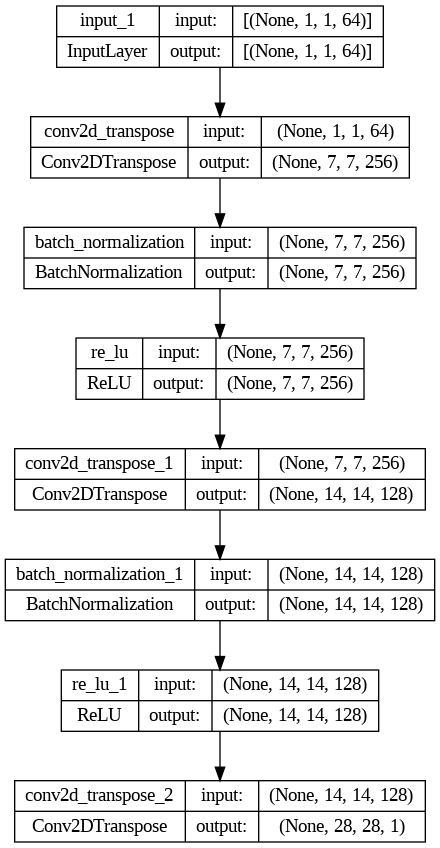

In [178]:
tf.keras.utils.plot_model(generator, show_shapes=True, show_layer_names=True)

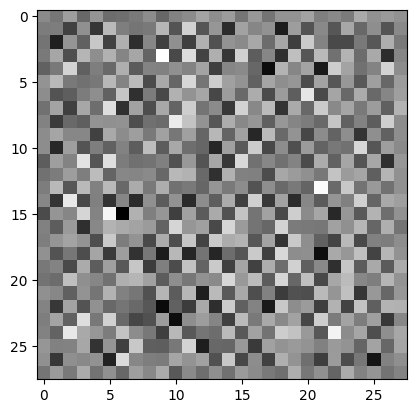

In [179]:
noise=tf.random.normal(shape=(1, 1, 1, z_dim))
fake_image=generator(noise, training=False)
plt.imshow((fake_image[0]+1)/2, cmap="gray");

In [180]:
def model_discriminator(input_shape=(28, 28, 1)):

  input=tf.keras.Input(shape=input_shape)
  x=tf.keras.layers.Conv2D(128, (4,4), strides=2, padding="same")(input)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(256, (4,4), strides=2, padding="same")(x)
  x=tf.keras.layers.BatchNormalization()(x)
  x=tf.keras.layers.LeakyReLU(0.2)(x)

  x=tf.keras.layers.Conv2D(1, (7,7), strides=1, padding="valid")(x)
  x=tf.keras.layers.Flatten()(x)

  model=tf.keras.Model(inputs=input, outputs=x, name="discriminator")

  return model

In [181]:
discriminator=model_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       2176      
                                                                 
 batch_normalization_2 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 256)         524544    
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                    

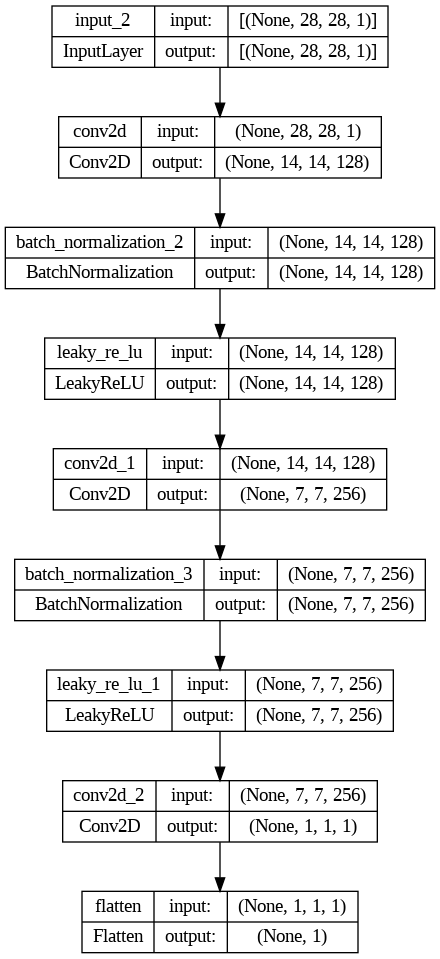

In [182]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [183]:
fake_out=discriminator(fake_image, training=False)
fake_out

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00024187]], dtype=float32)>

In [184]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
loss_model = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [185]:
@tf.function
def train_step(real_images):
  cur_batch_size=len(real_images)
  noise=tf.random.normal(shape=(cur_batch_size, 1, 1, z_dim))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    fake_images=generator(noise, training=True)

    real_out=discriminator(real_images, training=True)
    fake_out=discriminator(fake_images, training=True)

    # Generator Loss
    gen_loss=loss_model(tf.ones_like(fake_out), fake_out)

    # Discriminator Loss
    real_loss=loss_model(tf.ones_like(real_out), real_out)
    fake_loss=loss_model(tf.zeros_like(fake_out), fake_out)
    disc_loss = fake_loss+real_loss

  gradients_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))

  return gen_loss, disc_loss

In [186]:
# Delete image folder if it exists
!rm -r images
# Create image folder
!mkdir images

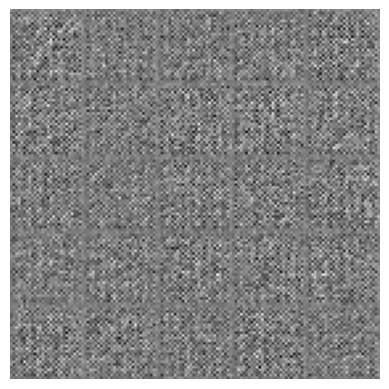

In [187]:
num_examples = 25
nrow = 5

noise = tf.random.normal((num_examples, 1, 1, z_dim))
fake_images = generator(noise, training=False)
fake_images = make_grid(fake_images, num_examples, nrow)
fake_images = tf.cast((fake_images+1) * 127.5, tf.uint8) # Denormalization

# Epoch 0 image
save_images = fake_images.numpy().squeeze()
images_gif_size = save_images.shape
save_images = Image.fromarray(save_images)
save_images = save_images.resize(images_gif_size)
save_images.save(f"images/image_at_epoch_{0:03d}.png")

plt.imshow(fake_images, cmap="gray")
plt.axis("off");

In [188]:
images_gif_size

(140, 140)

In [189]:
def train_gan(epochs=epochs, num_examples=num_examples, nrow=nrow, images_gif_size=images_gif_size, display_wait=False):
  history={"gen_loss":[], "disc_loss":[]}

  for epoch in range(epochs):
    gen_loss_list, disc_loss_list = [], []

    with tqdm(train_dataset) as pbar:
      pbar.set_description(f"[Epoch: {epoch+1}/{epochs}]")
      for real_images in pbar:
        gen_loss, disc_loss = train_step(real_images)

        gen_loss_list.append(gen_loss.numpy())
        disc_loss_list.append(disc_loss.numpy())

        pbar.set_postfix({"gen_loss": gen_loss.numpy(), "disc_loss": disc_loss.numpy()})

    gen_loss_mean = np.mean(gen_loss_list)
    disc_loss_mean = np.mean(disc_loss_list)
    history["gen_loss"].append(gen_loss_mean)
    history["disc_loss"].append(disc_loss_mean)

    display.clear_output(wait=display_wait)
    print(f"Epoch {epoch+1}, GeneratorLoss: {gen_loss_mean}, DiscriminatorLoss: {disc_loss_mean}")
    fake_images=generator(noise, training=False)

    show_and_save_images(real_images, fake_images, epoch+1, images_gif_size, num_examples, nrow)

  return history

Epoch 50, GeneratorLoss: 2.117607593536377, DiscriminatorLoss: 0.6244547367095947


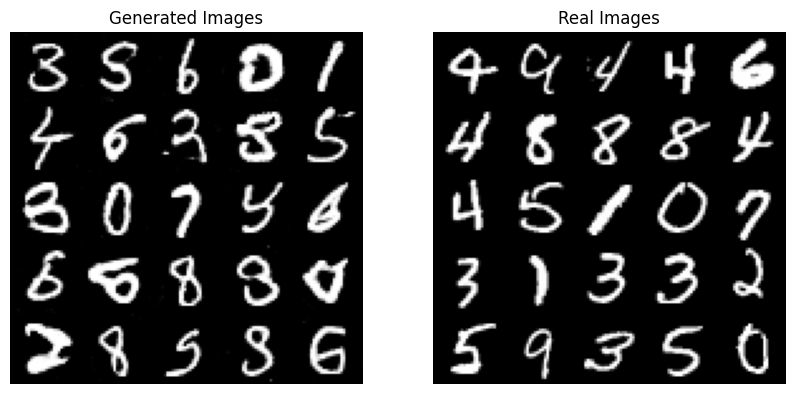

In [190]:
tf.random.set_seed(123)

history = train_gan()

In [191]:
# Interactive graphic
plot_metrics(history, epochs=epochs)

**Create a GIF from the generated images**

In [192]:
gif_file = "DCGAN_MNIST.gif"

In [193]:
def create_gif(gif_file):
  with imageio.get_writer(gif_file, mode="I") as writer:
    filenames = sorted(glob.glob("images/*.png"))
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [202]:
create_gif(gif_file)

In [151]:
!pip install tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 5.5 MB/s eta 0:00:00



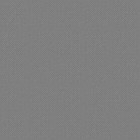

In [203]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(gif_file)

**Generated Example**

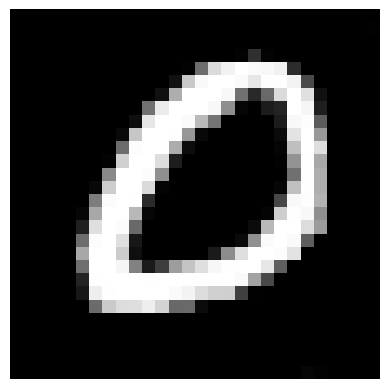

In [201]:
example=tf.random.normal(shape=(1, 1, 1, z_dim))
generated_example=generator(example)[0]
plt.imshow(generated_example, cmap="gray")
plt.axis("off");